In [ ]:
"""
File Created: 2024-08-12
Author: Patrick G. Cho
Contact: pcho@nd.edu
Purpose: Non-Stationary Relationship Exploration

Details:
This script can be used to analyze the role of the Indian and Pacific Ocean SSTs. The foundation of this code can be used to recreate Figure 3, 5, 6, S5, and S6. The differences between Figures 3/5 (ECHAM5-wiso) and 6 (ilme) is just the data. The figures were then adjusted in Affinity Designer. 
"""

# Load Packages and Data

In [1]:
# Data Management
import pandas as pd
import xarray as xr
import dask.array as dask
import cftime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Analysis
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
import pyleoclim as pyleo

# Calculations
from amount_weighted_ann_mean import amount_weighted_ann_mean
from weighted_temporal_mean import weighted_temporal_mean
from spatial_corr import compute_correlations
from preprocess_xr import preprocess_dataset
# Image Resolution on MacOS
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def calc_anom(data, time_dim='time', month_dim='month'):
    monthly_mean = data.groupby(f'{time_dim}.{month_dim}').mean(dim=time_dim)
    anomalies = data.groupby(f'{time_dim}.{month_dim}') - monthly_mean
    
    return anomalies

In [3]:
def rolling_corr_pvalue(series1, series2, window): 
    corr = []
    p_values = []
    
    # The rolling window will be centered
    half_window = (window - 1) // 2
    
    for i in range(half_window, len(series1) - half_window):
        segment1 = series1[i - half_window:i + half_window + 1]
        segment2 = series2[i - half_window:i + half_window + 1]
        
        if segment1.isnull().any() or segment2.isnull().any():
            corr.append(np.nan)
            p_values.append(np.nan)
        else:
            r, p = pearsonr(segment1, segment2)
            corr.append(r)
            p_values.append(p)
    
    # We need to adjust the index to reflect the centered window (starting from the middle of the window)
    corr_series = pd.Series(corr, index=series1.index[half_window:len(series1) - half_window])
    p_values_series = pd.Series(p_values, index=series1.index[half_window:len(series1) - half_window])
    
    return corr_series, p_values_series

In [4]:
def plot_corr(ax, title, data, tenth_percentile, ninetieth_percentile, tenth_percentile_n, ninetieth_percentile_n):
    # Positive Correlations
    scatter1 = data.where((data.values >= ninetieth_percentile) & (data.values > 0)).dropna()
    scatter2 = data.where((data.values <= tenth_percentile) & (data.values > 0)).dropna()

    # Negative Correlations
    scatter3 = data.where((data.values <= tenth_percentile_n) & (data.values < 0)).dropna() # strongest negative correlations, opposite because of signs
    scatter4 = data.where((data.values >= ninetieth_percentile_n) & (data.values < 0)).dropna()
    
    ax.fill_between(data.index, data, 0, where=(data > 0), color='firebrick', interpolate=True, alpha=0.6)
    ax.fill_between(data.index, data, 0, where=(data < 0), color='dodgerblue', interpolate=True, alpha=0.6)

    ax.axhline(y=tenth_percentile, color='k', linestyle='--', label='Weak Positive')
    ax.axhline(y=ninetieth_percentile, color='k', linestyle='--', label='Strong Positive')
    ax.axhline(y=0, color='k', linestyle='-')
    ax.axhline(y=tenth_percentile_n, color='k', linestyle='dotted', label='Strong Negative')
    ax.axhline(y=ninetieth_percentile_n, color='k', linestyle='dotted', label='Weak Negative')
    
    ax.scatter(scatter1.index, scatter1.values, color='orangered', marker='o') # Strong Positive
    ax.scatter(scatter2.index, scatter2.values, color='orange', marker='o') # Weak Positive
    ax.scatter(scatter3.index, scatter3.values, color='blue', marker='^')# Strong Negative
    ax.scatter(scatter4.index, scatter4.values, color='cyan', marker='^')# Weak Negative
    
    ax.set_ylim(-1.0, 1.0)
    ax.set_yticks(np.arange(-1.0, 1.2, 0.2))
    ax.set_ylabel(title, fontweight='bold')

In [5]:
# Define the function to create 15-year mask
def create_15_year_mask(dataset, years, window_size=15):
    mask_years = []
    for year in years:
        start_year = year - (window_size // 2)
        end_year = year + (window_size // 2)
        mask_years.extend(range(start_year, end_year + 1))
    
    # Remove duplicates and sort the years
    mask_years = sorted(set(mask_years))
    return mask_years

In [6]:
def calculate_sign_agreement(anomaly_maps, composite_years, threshold=0.8):
    """
    Calculate a stippling mask based on whether each grid cell exceeds the threshold of sign agreement
    for either positive or negative anomalies over a specified period.
    
    Parameters:
    - anomaly_maps (xarray.DataArray): The array containing anomaly data over time.
    - composite_years (list or array): The years to include in the composite analysis.
    - threshold (float): The minimum fraction of years that must agree on the sign of the anomaly.
    
    Returns:
    - stippling_mask (xarray.DataArray): A boolean mask indicating cells with at least `threshold` agreement.
    """
    # Select anomalies for the specified composite years
    composite_anomalies = anomaly_maps.sel(time=anomaly_maps['time.year'].isin(composite_years))
    
    # Determine the sign of each year's anomaly (+1 for positive, -1 for negative, 0 to deal with land-sea masks, which often put values as 0)
    sign_map = xr.where(composite_anomalies > 0, 1, xr.where(composite_anomalies < 0, -1, 0))
    
    # Calculate the number of years with positive or negative anomalies
    positive_agreement = (sign_map == 1).sum(dim='time') / len(composite_years)
    negative_agreement = (sign_map == -1).sum(dim='time') / len(composite_years)
    
    # Create a mask for cells with agreement exceeding the threshold for either positive or negative signs
    stippling_mask = (positive_agreement >= threshold) | (negative_agreement >= threshold)
    
    return stippling_mask

In [7]:
path = 'YourPath'
path2 = 'YourPath2'

In [8]:
# Load Metrics; Study period 1958 to 2005 and 850-2005

ilme = pd.read_csv(path+'ONDiLMEMetrics.csv') #these are already specified for oct, nov, dec
dfo = ilme.set_index('Year')
dfMod = dfo[(dfo.index >= 1958) & (dfo.index <= 2005)] # 1958-2005

############################### Gridded Data ###############################
# d18OP and Precip
ds001 = calc_anom(preprocess_dataset(path2 + 'ilme1d18O.nc'))
ds001 = ds001.where(ds001['time'].dt.month.isin([10, 11, 12]), drop=True).resample(time='Y').mean()
ds002 = calc_anom(preprocess_dataset(path2 + 'ilme2d18O.nc'))
ds002 = ds002.where(ds002['time'].dt.month.isin([10, 11, 12]), drop=True).resample(time='Y').mean()
ds003 = calc_anom(preprocess_dataset(path2 + 'ilme3d18O.nc'))
ds003 = ds003.where(ds003['time'].dt.month.isin([10, 11, 12]), drop=True).resample(time='Y').mean()

# OND SSTs; Already in Anomalies
sst001 = xr.open_dataset(path+'ilme1SST.nc').rename({'__xarray_dataarray_variable__':'SST'})
sst002 = xr.open_dataset(path+'ilme2SST.nc').rename({'__xarray_dataarray_variable__':'SST'})
sst003 = xr.open_dataset(path+'ilme3SST.nc').rename({'__xarray_dataarray_variable__':'SST'})

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


In [9]:
sst001 = calc_anom(sst001)
sst002 = calc_anom(sst002)
sst003 = calc_anom(sst003)

In [10]:
# iLME for 1958-2005

# iLME Full Forcing 001; OND
p1m = pyleo.Series(time = dfMod.index, value = dfMod.SLP_PWC_001, label = '$\delta SLP_{PWC}$', 
                   time_name = 'Time', value_name = 'SLP Anomalies', 
                   time_unit = 'Year C.E.', value_unit = 'permille').standardize()
u1m = pyleo.Series(time = dfMod.index, value = dfMod.UEQ_001, label = 'U_{Eq}$', 
                   time_name = 'Time', value_name = 'Wind Anomalies', 
                   time_unit = 'Year C.E.', value_unit = 'permille').standardize()

# iLME Full Forcing 002; OND
p2m = pyleo.Series(time = dfMod.index, value = dfMod.SLP_PWC_002, label = '$\delta SLP_{PWC}$', 
                   time_name = 'Time', value_name = 'SLP Anomalies', 
                   time_unit = 'Year C.E.', value_unit = 'permille').standardize()
u2m = pyleo.Series(time = dfMod.index, value = dfMod.UEQ_002, label = 'U_{Eq}$', 
                   time_name = 'Time', value_name = 'Wind Anomalies', 
                   time_unit = 'Year C.E.', value_unit = 'permille').standardize()

# iLME Full Forcing 003; OND
p3m = pyleo.Series(time = dfMod.index, value = dfMod.SLP_PWC_003, label = '$\delta SLP_{PWC}$', 
                   time_name = 'Time', value_name = 'SLP Anomalies', 
                   time_unit = 'Year C.E.', value_unit = 'permille').standardize()
u3m = pyleo.Series(time = dfMod.index, value = dfMod.UEQ_003, label = 'U_{Eq}$', 
                   time_name = 'Time', value_name = 'Wind Anomalies', 
                   time_unit = 'Year C.E.', value_unit = 'permille').standardize()

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order


/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_40898/1743547857.py:4: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True, which might modify your supplied time metadata.  Please set to False if you want a different behavior.
  p1m = pyleo.Series(time = dfMod.index, value = dfMod.SLP_PWC_001, label = '$\delta SLP_{PWC}$',
/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_40898/1743547857.py:7: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True, which might modify your supplied time metadata.  Please set to False if you want a different behavior.
  u1m = pyleo.Series(time = dfMod.index, value = dfMod.UEQ_001, label = 'U_{Eq}$',
/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_40898/1743547857.py:12: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True, which might modify your supplied time metadata.  Please set to False if you want a d

# Rolling Window Correlation 850-2005

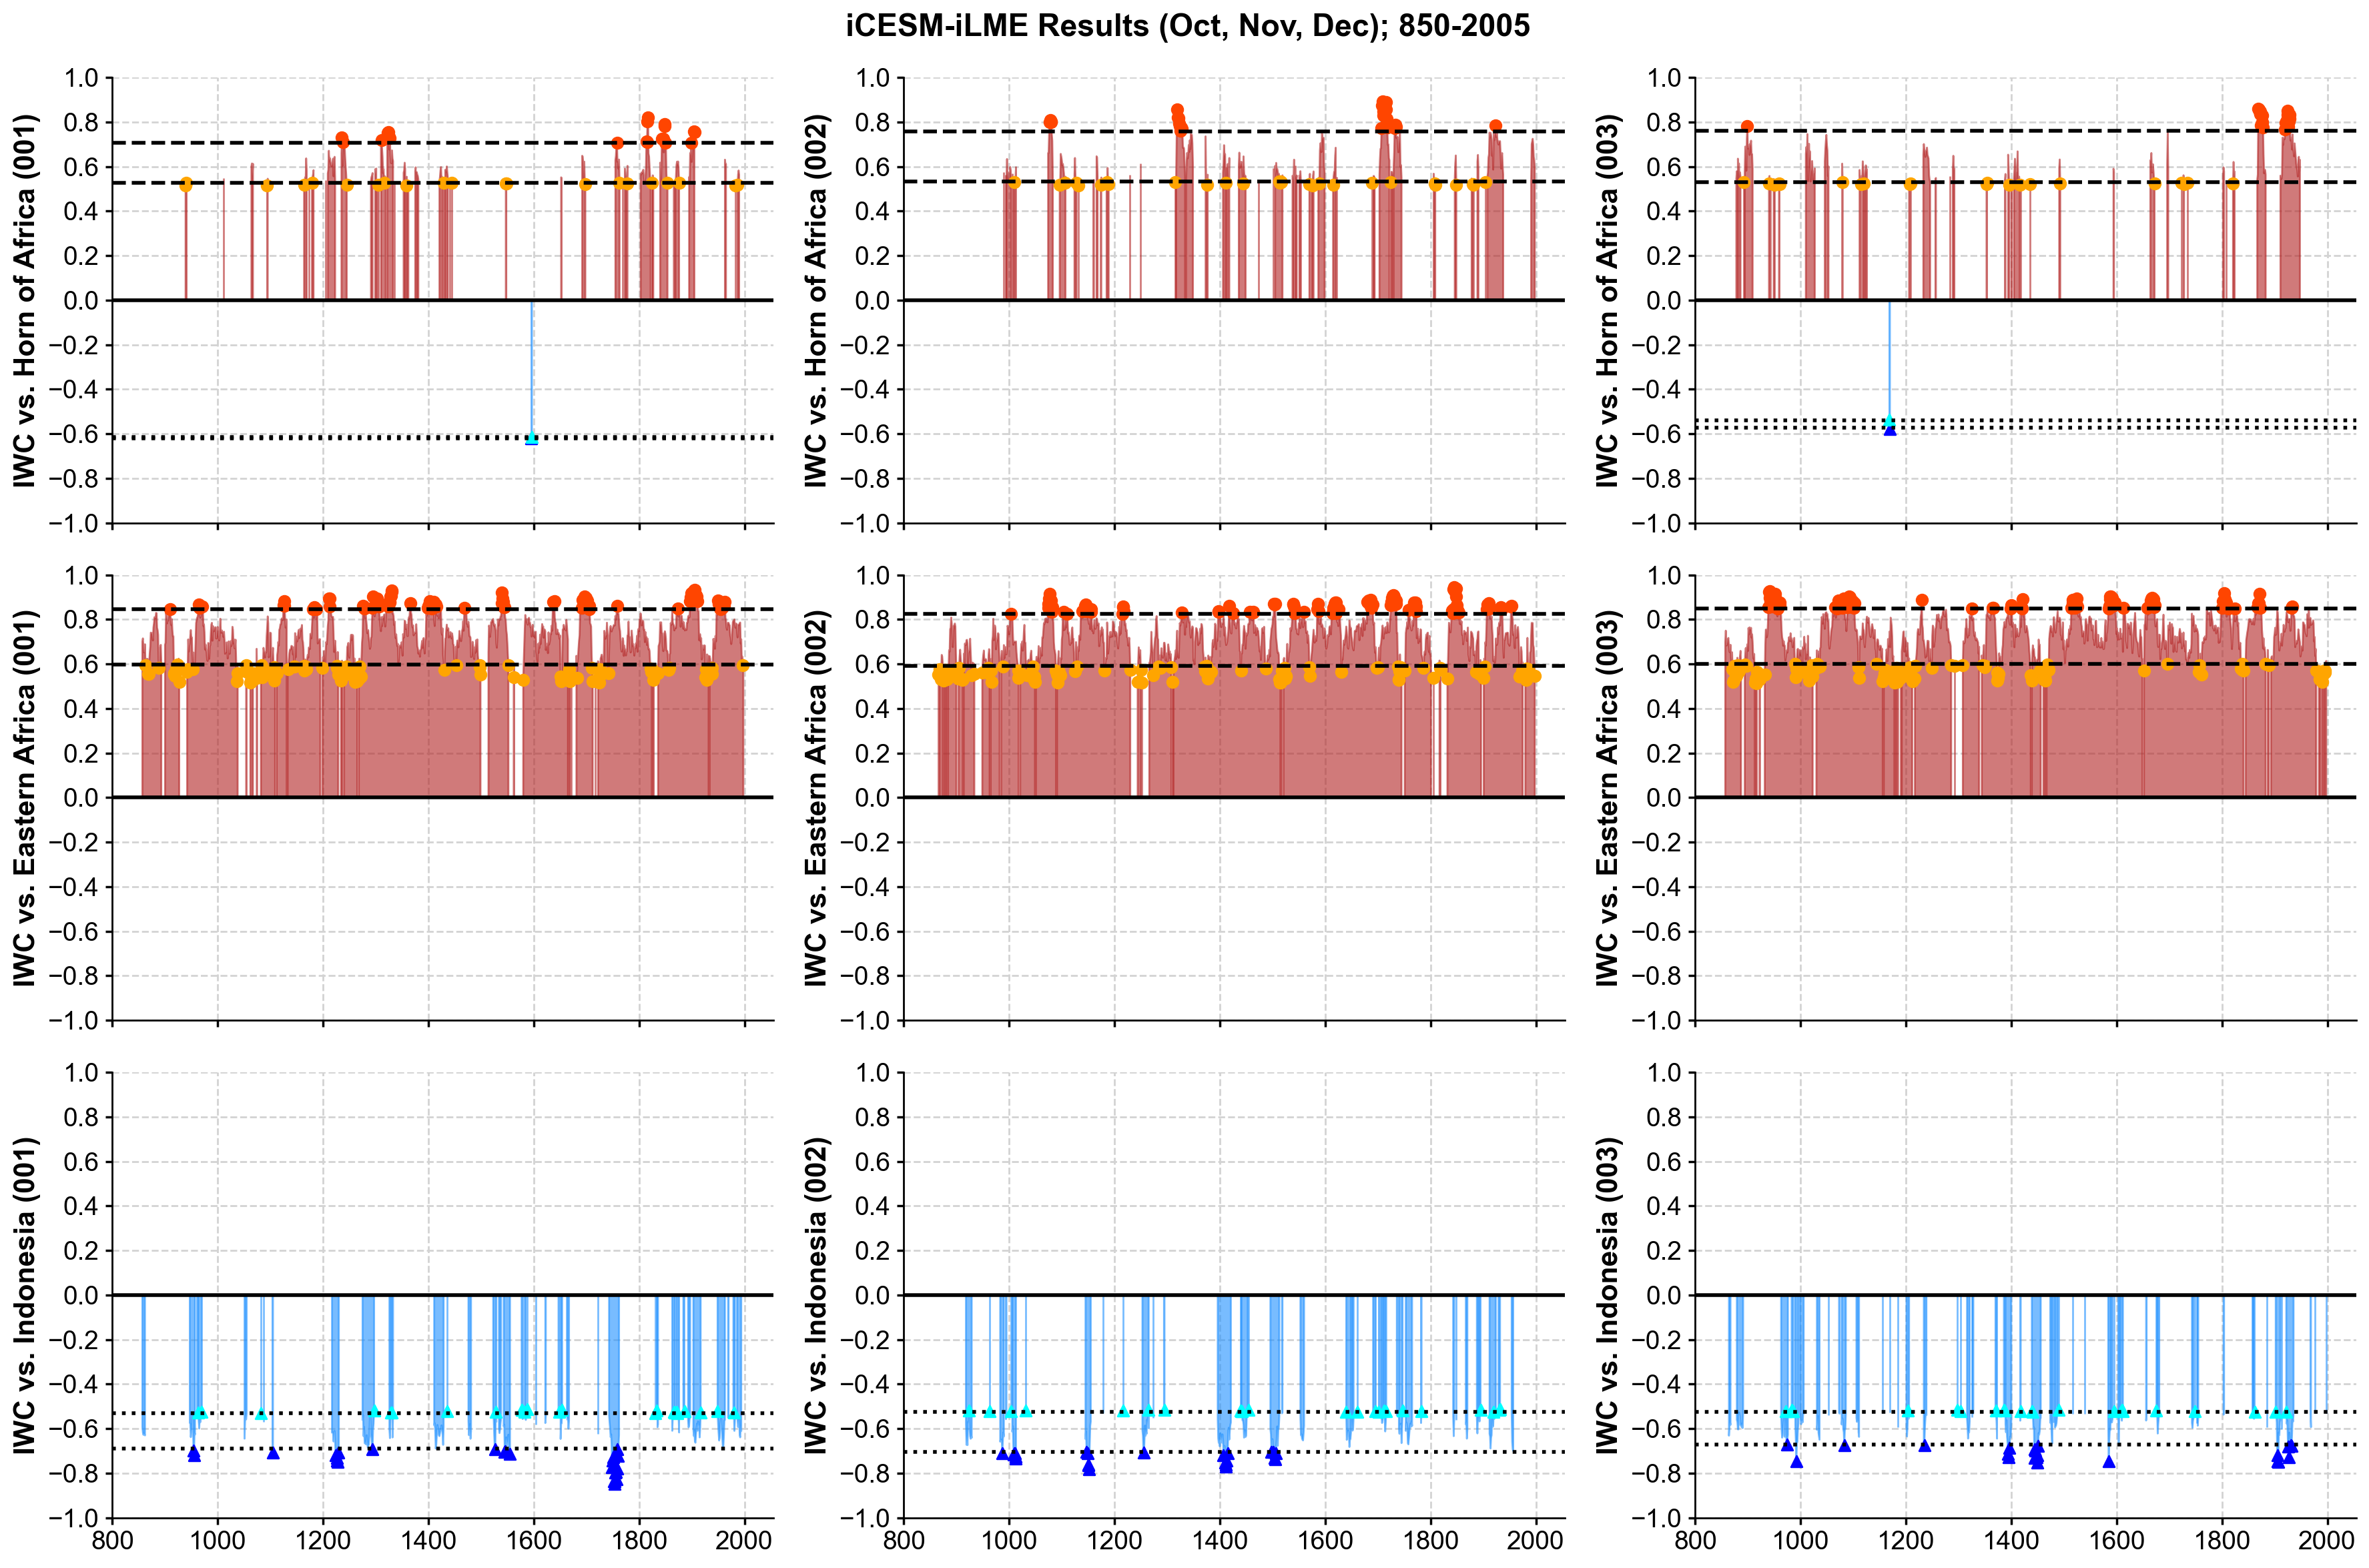

In [11]:
iterations = ['001', '002', '003']
fig, axs = plt.subplots(3, len(iterations), figsize=(len(iterations) * 6, 12), sharex=True)

result_dict = {}

for col_idx, iteration in enumerate(iterations):
    df = dfo.copy()

    # 15 Year Rolling Window; 15 data points to calculate correlations
    rolling_corr_hrn, p_values_hrn = rolling_corr_pvalue(df[f'UEQ_{iteration}'], df[f'horn{iteration}_PREC_d18O'], window=15)
    rolling_corr_knya, p_values_knya = rolling_corr_pvalue(df[f'UEQ_{iteration}'], df[f'k{iteration}_PREC_d18O'], window=15)
    rolling_corr_indo, p_values_indo = rolling_corr_pvalue(df[f'UEQ_{iteration}'], df[f'indo{iteration}_PREC_d18O'], window=15)
    
    significant_hrn = rolling_corr_hrn.where(p_values_hrn < 0.05) # Filter for Significant Correlations (p-value < 0.05)
    significant_knya = rolling_corr_knya.where(p_values_knya < 0.05)
    significant_indo = rolling_corr_indo.where(p_values_indo < 0.05)
    
    h = significant_hrn.where(significant_hrn > 0)
    k = significant_knya.where(significant_knya > 0)
    i = significant_indo.where(significant_indo > 0)
    
    hn = significant_hrn.where(significant_hrn < 0)
    kn = significant_knya.where(significant_knya < 0)
    In = significant_indo.where(significant_indo < 0)
    
    tenth_percentile_hrn = h.quantile(0.10)
    ninetieth_percentile_hrn = h.quantile(0.90) # Strongest Positive Correlation is 90th Percentile 
    
    tenth_percentile_knya = k.quantile(0.10)
    ninetieth_percentile_knya = k.quantile(0.90)
    
    tenth_percentile_indo = i.quantile(0.10)
    ninetieth_percentile_indo = i.quantile(0.90)

    # Negative Correlations
    tenth_percentile_hrn_n = hn.quantile(0.10) # Strongest Negative correlation is 10th percentile
    ninetieth_percentile_hrn_n = hn.quantile(0.90)
    
    tenth_percentile_knya_n = kn.quantile(0.10)
    ninetieth_percentile_knya_n = kn.quantile(0.90)
    
    tenth_percentile_indo_n = In.quantile(0.10)
    ninetieth_percentile_indo_n = In.quantile(0.90)

    iteration_results = {
        'Strong_Positive_Horn': h.where((h >= ninetieth_percentile_hrn) & (h > 0)).dropna().index.values,
        'Weak_Positive_Horn': h.where((h <= tenth_percentile_hrn) & (h > 0)).dropna().index.values,
        'Strong_Positive_Eastern': k.where((k >= ninetieth_percentile_knya) & (k > 0)).dropna().index.values,
        'Weak_Positive_Eastern': k.where((k <= tenth_percentile_knya) & (k > 0)).dropna().index.values,
    }

    # Create the DataFrame, filling with NaN where necessary
    iteration_results_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in iteration_results.items()]))

    # Add iteration information to the results
    iteration_results_df['Iteration'] = iteration

    # Append results to the main result dictionary
    result_dict[iteration] = iteration_results_df

    plot_corr(axs[0, col_idx], f'IWC vs. Horn of Africa ({iteration})', significant_hrn, tenth_percentile_hrn, ninetieth_percentile_hrn, tenth_percentile_hrn_n, ninetieth_percentile_hrn_n)
    plot_corr(axs[1, col_idx], f'IWC vs. Eastern Africa ({iteration})', significant_knya, tenth_percentile_knya, ninetieth_percentile_knya, tenth_percentile_knya_n, ninetieth_percentile_knya_n)
    plot_corr(axs[2, col_idx], f'IWC vs. Indonesia ({iteration})', significant_indo, tenth_percentile_indo, ninetieth_percentile_indo, tenth_percentile_indo_n, ninetieth_percentile_indo_n)

fig.suptitle('iCESM-iLME Results (Oct, Nov, Dec); 850-2005', fontweight='bold')
plt.tight_layout()
plt.savefig('SaveFig.pdf',bbox_inches='tight',dpi=300)
plt.show()

final_result_df = pd.concat(result_dict.values(), ignore_index=True)

In [12]:
df1 = final_result_df.groupby('Iteration').get_group('001')
df2 = final_result_df.groupby('Iteration').get_group('002')
df3 = final_result_df.groupby('Iteration').get_group('003')

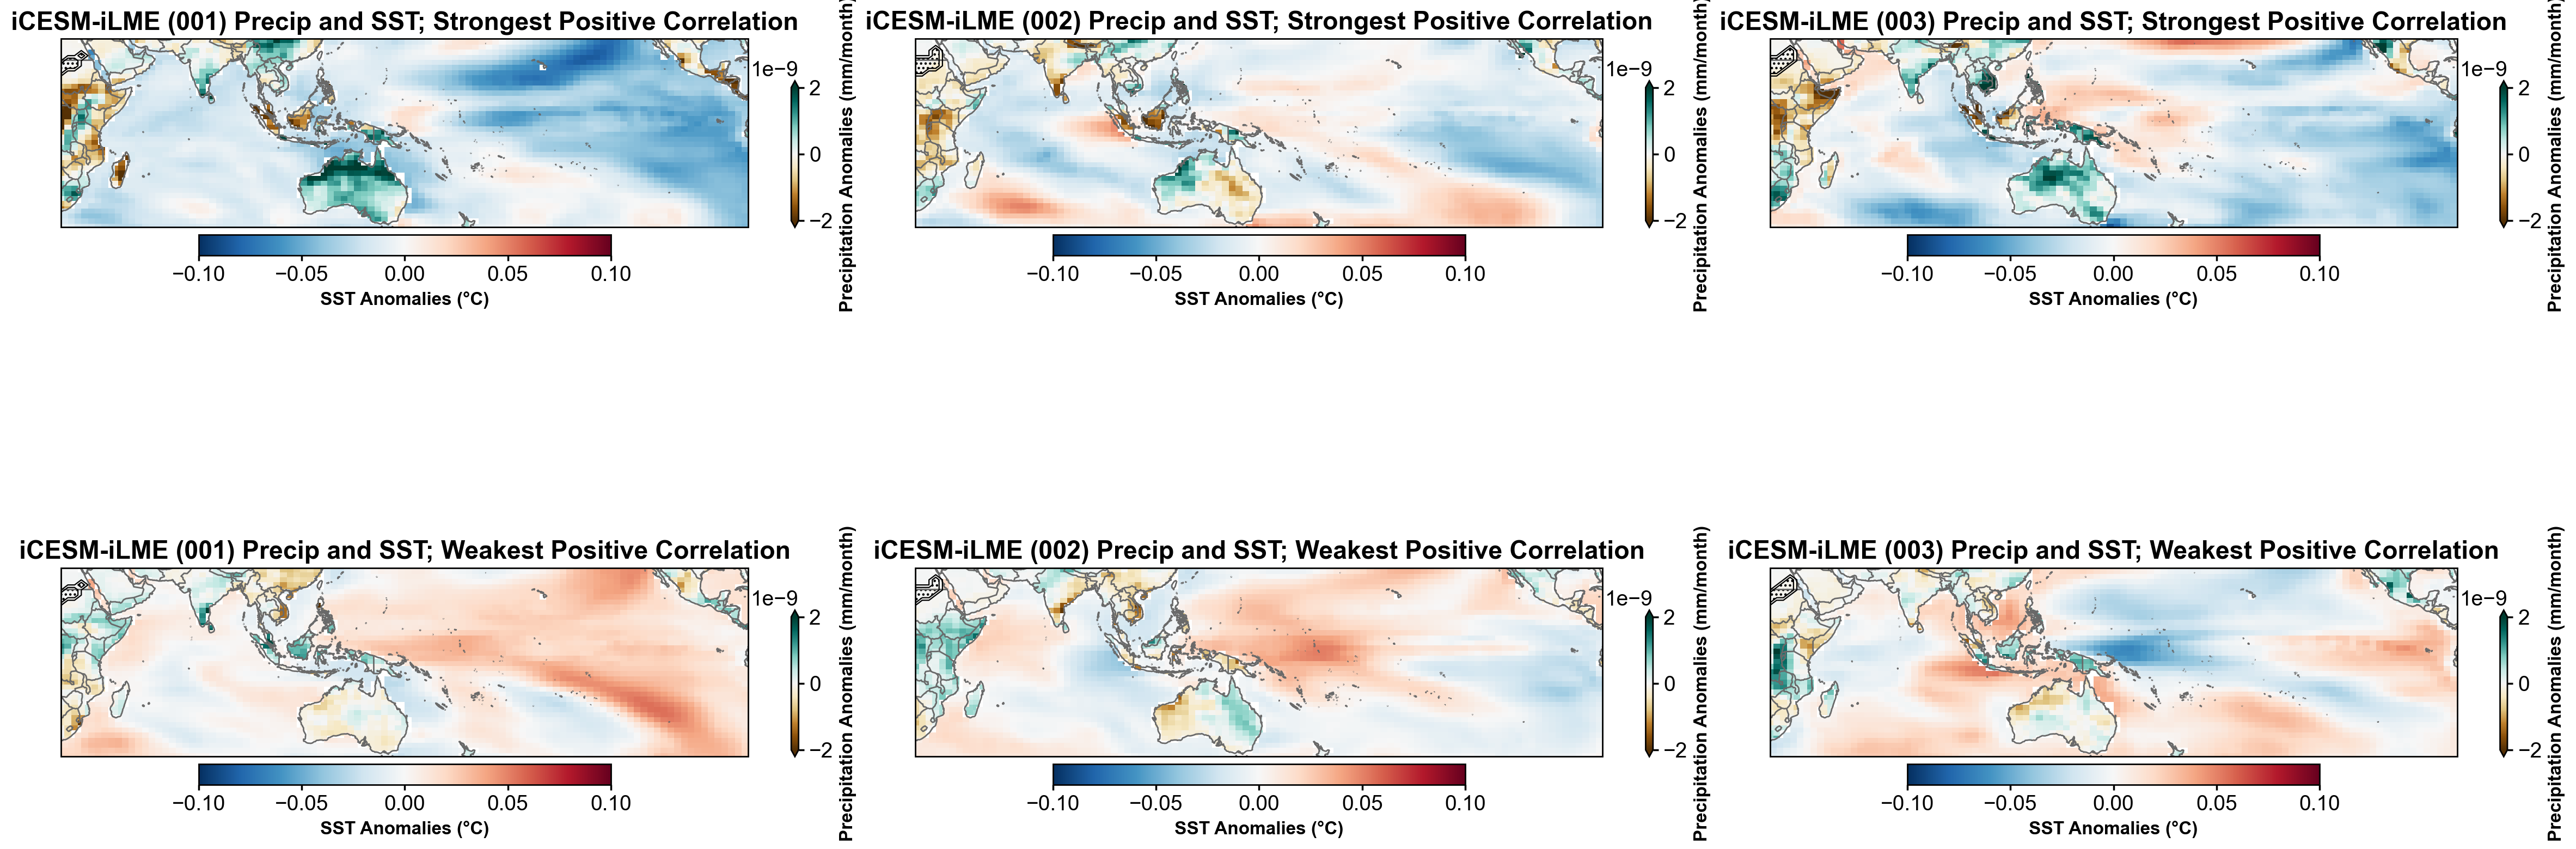

In [35]:
iterations = ['001', '002', '003']
norm_sst = mpl.colors.TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=0.1)

# Define custom precipitation colorbar range
precip_min_all = -2e-09
precip_max_all = 2e-09

fig, axs = plt.subplots(2, len(iterations), figsize=(len(iterations)*8, 12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

for col_idx, iteration in enumerate(iterations):
    strn = np.union1d(final_result_df.groupby('Iteration').get_group(iteration)['Strong_Positive_Horn'].dropna().values,
                      final_result_df.groupby('Iteration').get_group(iteration)['Strong_Positive_Eastern'].dropna().values)

    ds_name = eval(f'ds{iteration}')  
    map_name = eval(f'sst{iteration}') 
    
    maska = create_15_year_mask(ds_name, strn.astype(np.int64))
    masksst = create_15_year_mask(map_name, strn.astype(np.int64))

    agrees = calculate_sign_agreement(ds_name, maska)
    agreessts = calculate_sign_agreement(map_name, masksst)

    wk = np.union1d(final_result_df.groupby('Iteration').get_group(iteration)['Weak_Positive_Horn'].dropna().values,
                      final_result_df.groupby('Iteration').get_group(iteration)['Weak_Positive_Eastern'].dropna().values)
    
    maskw = create_15_year_mask(ds_name, wk.astype(np.int64))
    masksstw = create_15_year_mask(map_name, wk.astype(np.int64))    

    agreew = calculate_sign_agreement(ds_name, maskw)
    agreesstw = calculate_sign_agreement(map_name, masksstw)
    
    ax_strong = axs[0, col_idx]
    precip_plot_strong = ds_name.sel(time=ds_name.time.dt.year.isin(maska)).PREC.mean(dim='time').plot(
        ax=ax_strong, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree(),
        vmin=precip_min_all, vmax=precip_max_all)  
    ax_strong.contourf(agrees.Longitude, agrees.Latitude, agrees.PREC, 1, colors="none", hatches=[None,'....'], transform=ccrs.PlateCarree())
    ax_strong.contour(agrees.Longitude, agrees.Latitude, agrees.PREC, levels=1, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())
    
    sst_plot_strong = map_name.sel(time=map_name.time.dt.year.isin(masksst)).SST.mean(dim='time').plot(
        x='lon', y='lat', ax=ax_strong, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree(),
        norm=norm_sst) 
    ax_strong.contourf(agreessts.lon, agreessts.lat, agreessts.SST.mean(dim='z_t'), 1, colors="none", hatches=[None,'....'], transform=ccrs.PlateCarree())
    ax_strong.contour(agreessts.lon, agreessts.lat, agreessts.SST.mean(dim='z_t'), levels=1, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())
    
    cbar_strong_precip = fig.colorbar(precip_plot_strong, ax=ax_strong, orientation='vertical', shrink=0.2, anchor=(0, 0.2), extend='both')
    cbar_strong_precip.set_label(r'Precipitation Anomalies (mm/month)', fontsize=12, fontweight='bold')
    cbar_strong_sst = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap='RdBu_r'), ax=ax_strong, orientation='horizontal', shrink=0.6, pad=0.01)
    cbar_strong_sst.set_label('SST Anomalies (°C)', fontsize=12, fontweight='bold')
    
    ax_strong.set_extent([25, 280, -40, 30], ccrs.PlateCarree())
    ax_strong.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='dimgrey')
    ax_strong.add_feature(cfeature.BORDERS, edgecolor='dimgrey')
    ax_strong.set_title(f'iCESM-iLME ({iteration}) Precip and SST; Strongest Positive Correlation', fontweight='bold')
    
    ax_weak = axs[1, col_idx]
    precip_plot_weak = ds_name.sel(time=ds_name.time.dt.year.isin(maskw)).PREC.mean(dim='time').plot(
        ax=ax_weak, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree(),
        vmin=precip_min_all, vmax=precip_max_all)  
    ax_weak.contourf(agreew.Longitude, agreew.Latitude, agreew.PREC, 1, colors="none", hatches=[None,'....'], transform=ccrs.PlateCarree())
    ax_weak.contour(agreew.Longitude, agreew.Latitude, agreew.PREC, levels=1, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())
    
    sst_plot_weak = map_name.sel(time=ds_name.time.dt.year.isin(masksstw)).SST.mean(dim='time').plot(
        x='lon', y='lat', ax=ax_weak, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree(),
        norm=norm_sst)  
    ax_weak.contourf(agreesstw.lon, agreesstw.lat, agreesstw.SST.mean(dim='z_t'), 1, colors="none", hatches=[None,'....'], transform=ccrs.PlateCarree())
    ax_weak.contour(agreesstw.lon, agreesstw.lat, agreesstw.SST.mean(dim='z_t'), levels=1, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())
    
    # Add colorbars manually
    cbar_weak_precip = fig.colorbar(precip_plot_weak, ax=ax_weak, orientation='vertical', shrink=0.2, anchor=(0, 0.2), extend='both')
    cbar_weak_precip.set_label(r'Precipitation Anomalies (mm/month)', fontsize=12, fontweight='bold')
    cbar_weak_sst = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap='RdBu_r'), ax=ax_weak, orientation='horizontal', shrink=0.6, pad=0.01)
    cbar_weak_sst.set_label('SST Anomalies (°C)', fontsize=12, fontweight='bold')
    
    ax_weak.set_extent([25, 280, -40, 30], ccrs.PlateCarree())
    ax_weak.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='dimgrey')
    ax_weak.add_feature(cfeature.BORDERS, edgecolor='dimgrey')
    ax_weak.set_title(f'iCESM-iLME ({iteration}) Precip and SST; Weakest Positive Correlation', fontweight='bold')

plt.tight_layout()
plt.savefig('SaveFig.pdf',bbox_inches='tight',dpi=300)

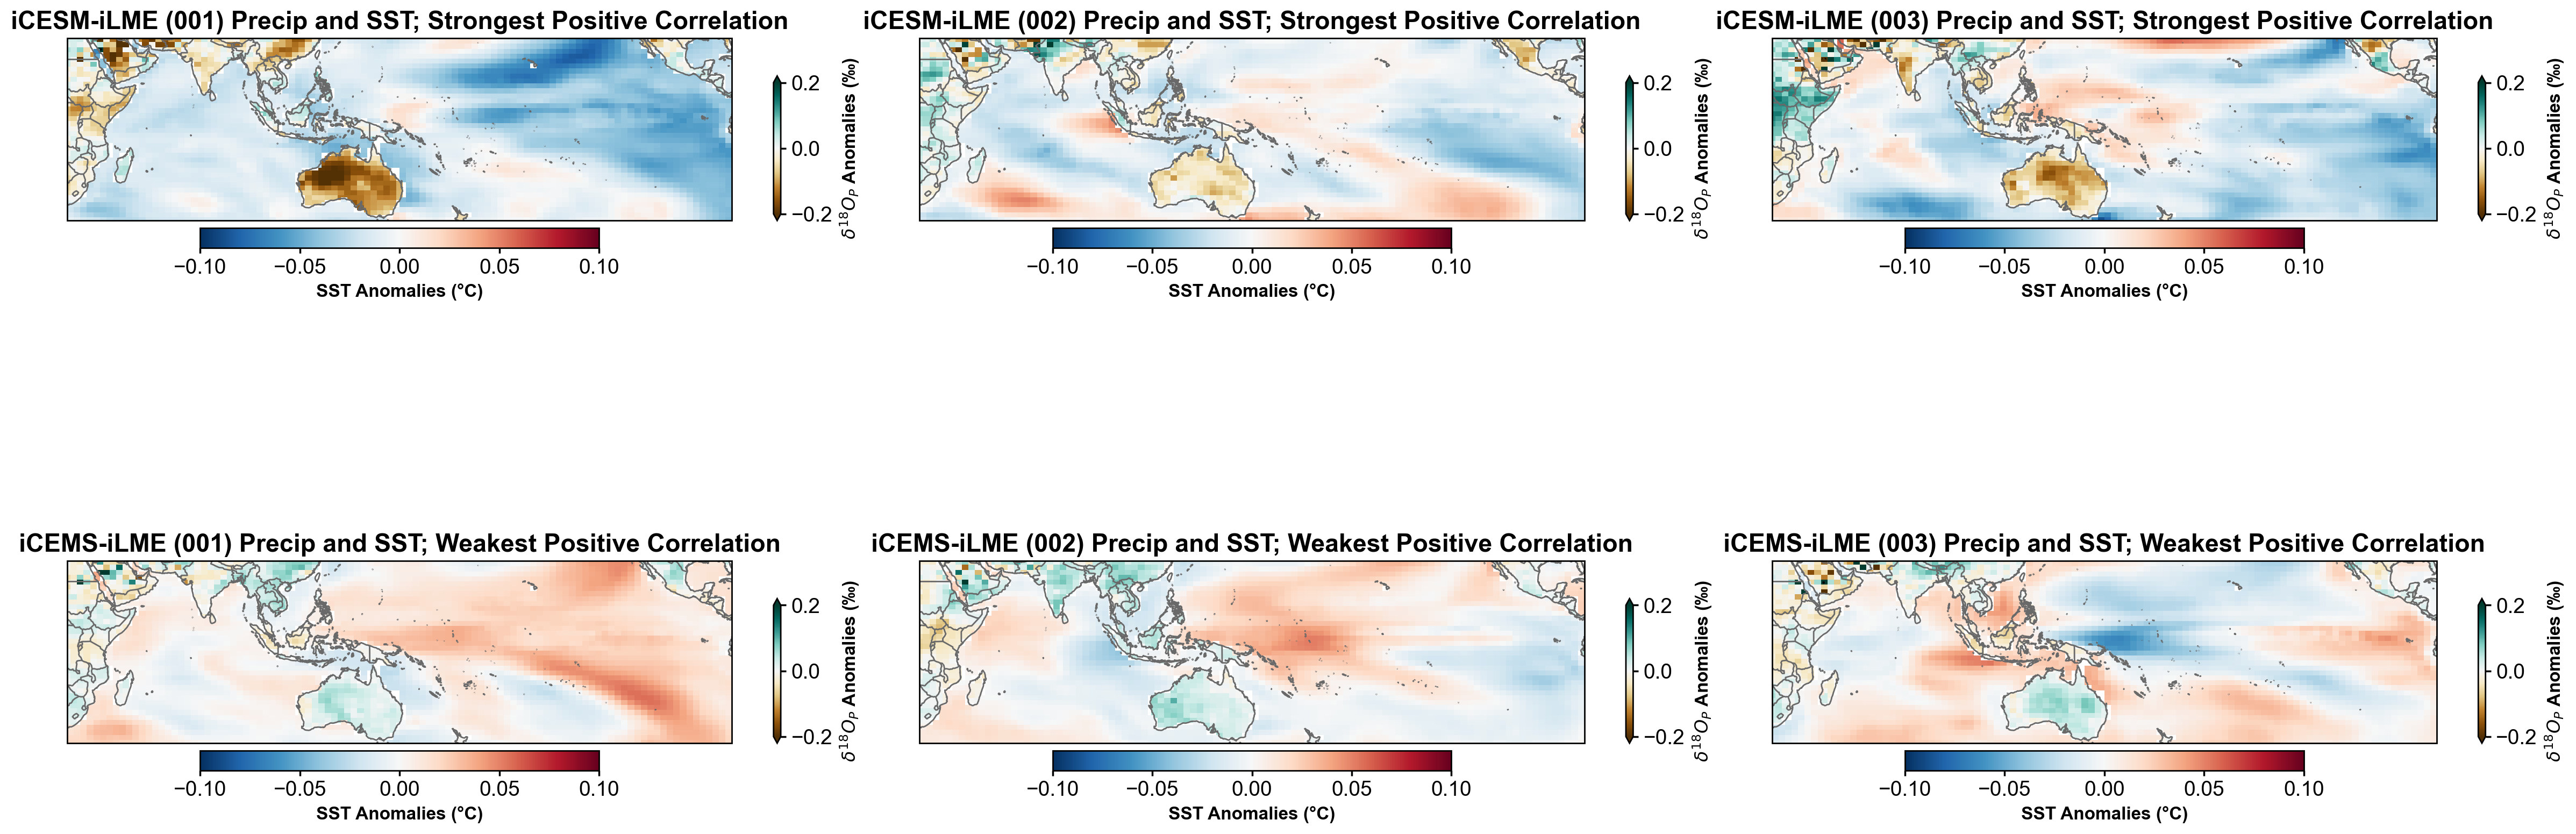

In [37]:
# iterations = ['001', '002', '003']
norm_sst = mpl.colors.TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=0.1)
norm_d18O = mpl.colors.TwoSlopeNorm(vmin=-0.2, vcenter=0, vmax=0.2)
fig, axs = plt.subplots(2, len(iterations), figsize=(len(iterations)*8, 12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

for col_idx, iteration in enumerate(iterations):
    strn = np.union1d(final_result_df.groupby('Iteration').get_group(iteration)['Strong_Positive_Horn'].dropna().values,
                      final_result_df.groupby('Iteration').get_group(iteration)['Strong_Positive_Eastern'].dropna().values)

    ds_name = eval(f'ds{iteration}')  
    map_name = eval(f'sst{iteration}') 
    maska = create_15_year_mask(ds_name, strn.astype(np.int64))
    masksst = create_15_year_mask(map_name, strn.astype(np.int64))

    agrees = calculate_sign_agreement(ds_name, maska)
    agreessts = calculate_sign_agreement(map_name, masksst)

    #precip_min = eval('ds001').sel(time=maska).PREC_d18O.mean(dim='time').min().values
    #precip_max = eval('ds001').sel(time=maska).PREC_d18O.mean(dim='time').max().values
    
    wk = np.union1d(final_result_df.groupby('Iteration').get_group(iteration)['Weak_Positive_Horn'].dropna().values,
                      final_result_df.groupby('Iteration').get_group(iteration)['Weak_Positive_Eastern'].dropna().values)
    
    maskw = create_15_year_mask(ds_name, wk.astype(np.int64))
    masksstw = create_15_year_mask(map_name, wk.astype(np.int64))    

    agreew = calculate_sign_agreement(ds_name, maskw)
    agreesstw = calculate_sign_agreement(map_name, masksstw)

    ax_strong = axs[0, col_idx]
    precip_plot_strong = ds_name.sel(time=ds_name.time.dt.year.isin(maska)).PREC_d18O.mean(dim='time').plot( ######### This is for d18OP!!!!!!!!
        ax=ax_strong, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree(),
        norm=norm_d18O)  
    ax_strong.contourf(agrees.Longitude, agrees.Latitude, agrees.PREC_d18O, 1, colors="none", hatches=[None,'....'], transform=ccrs.PlateCarree())
    sst_plot_strong = map_name.sel(time=ds_name.time.dt.year.isin(masksst)).SST.mean(dim='time').plot(
        x='lon', y='lat', ax=ax_strong, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree(),
        norm=norm_sst)  # Use normalization for SST with 0 as white
    ax_strong.contourf(agreessts.lon, agreessts.lat, agreessts.SST.mean(dim='z_t'), 1, colors="none", hatches=[None,'....'], transform=ccrs.PlateCarree())
    ax_strong.set_extent([25, 280, -40, 30], ccrs.PlateCarree())
    ax_strong.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='dimgrey')
    ax_strong.add_feature(cfeature.BORDERS, edgecolor='dimgrey')
    ax_strong.set_title(f'iCESM-iLME ({iteration}) Precip and SST; Strongest Positive Correlation', fontweight='bold')
    cbar_strong_precip = fig.colorbar(precip_plot_strong, ax=ax_strong, orientation='vertical', shrink=0.2, anchor=(0, 0.2), extend='both')
    cbar_strong_precip.set_label(r'$\delta^{18}O_P$ Anomalies (‰)', fontsize=12, fontweight='bold')
    cbar_strong_sst = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap='RdBu_r'), ax=ax_strong, orientation='horizontal', shrink=0.6, pad=0.01)
    cbar_strong_sst.set_label('SST Anomalies (°C)', fontsize=12, fontweight='bold')

    ax_weak = axs[1, col_idx]
    precip_plot_weak = ds_name.sel(time=ds_name.time.dt.year.isin(maskw)).PREC_d18O.mean(dim='time').plot( ######### This is for d18OP!!!!!!!!
        ax=ax_weak, cmap='BrBG', add_colorbar=False, transform=ccrs.PlateCarree(),
        norm=norm_d18O)  # Set precipitation colorbar limits
    ax_weak.contourf(agreew.Longitude, agreew.Latitude, agreew.PREC_d18O, 1, colors="none", hatches=[None,'....'], transform=ccrs.PlateCarree())
    sst_plot_weak = map_name.sel(time=ds_name.time.dt.year.isin(masksstw)).SST.mean(dim='time').plot(
        x='lon', y='lat', ax=ax_weak, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree(),
        norm=norm_sst)  # Use normalization for SST with 0 as white
    ax_weak.contourf(agreesstw.lon, agreesstw.lat, agreesstw.SST.mean(dim='z_t'), 1, colors="none", hatches=[None,'....'], transform=ccrs.PlateCarree())
    ax_weak.set_extent([25, 280, -40, 30], ccrs.PlateCarree())
    ax_weak.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='dimgrey')
    ax_weak.add_feature(cfeature.BORDERS, edgecolor='dimgrey')
    ax_weak.set_title(f'iCEMS-iLME ({iteration}) Precip and SST; Weakest Positive Correlation', fontweight='bold')
    cbar_weak_precip = fig.colorbar(precip_plot_weak, ax=ax_weak, orientation='vertical', shrink=0.2, anchor=(0, 0.2), extend='both')
    cbar_weak_precip.set_label(r'$\delta^{18}O_P$ Anomalies (‰)', fontsize=12, fontweight='bold')
    cbar_weak_sst = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sst, cmap='RdBu_r'), ax=ax_weak, orientation='horizontal', shrink=0.6, pad=0.01)
    cbar_weak_sst.set_label('SST Anomalies (°C)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('SaveFig.pdf',bbox_inches='tight',dpi=300)